# Toy notebook to make optimization fxns

In [1]:
import sys
import os
sys.path.append("src/")
from src import *
sys.path.append("scripts/")
from ixnos_retrain import *
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from Bio import SeqIO
import seaborn as sns
import random

ALPHA = "ACGT"  # Defines the possible nucleotides
NTS = ["A", "C", "G", "T"]  # Nucleotide list
CODONS = [x + y + z for x in ALPHA for y in ALPHA for z in ALPHA]
COD2ID = {codon: idx for idx, codon in enumerate(CODONS)}  # Codon to ID mapping
ID2COD = {idx: codon for codon, idx in COD2ID.items()}  # ID to Codon mapping
NT2ID = {nt: idx for idx, nt in enumerate(NTS)}  # Nucleotide to ID mapping
ID2NT = {idx: nt for nt, idx in NT2ID.items()}  # ID to Nucleotide mapping
NT_INDICES = np.arange(-15, 15)  # Nucleotide indices window
CODON_INDICES = np.arange(-5, 5)  # Codon indices window


In [2]:
model_path = "models/ixnos_retrained.pth"
model = iXnos()
model.load_state_dict(torch.load(model_path, weights_only=True))
# model = torch.load(model_path, weights_only=False)
model.eval()

iXnos(
  (layers): Sequential(
    (0): Linear(in_features=760, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=1, bias=True)
    (3): ReLU()
  )
)

## 1. Given nt seq, run iXnos model on all codons
(Except first/last 20)

In [3]:
iwasaki_dir = "iXnos/expts/iwasaki"
ydf_te = pd.read_csv(
    f"{iwasaki_dir}/process/te_set_bounds.size.27.30.trunc.20.20.min_cts.200.min_cod.100.top.500.data_table.txt",
    sep='\t')
ydf_tr = pd.read_csv(
    f"{iwasaki_dir}/process/tr_set_bounds.size.27.30.trunc.20.20.min_cts.200.min_cod.100.top.500.data_table.txt",
    sep='\t')
# Get the train and test genes
genes_te = ydf_te["gene"].unique()
genes_tr = ydf_tr["gene"].unique()
# Combine these dataframes and encode each codon
ydf = pd.concat([ydf_te, ydf_tr]).sort_values(by=["gene", "cod_idx"])
gdf_path = "iXnos/genome_data/human.transcripts.13cds10.transcripts.fa"
gdf = load_gdf(ydf, gdf_path)

In [4]:
# Just gonna grab a complete CDS for one gene
start_codon = "ATG"
stop_codons = ['TAA', 'TAG', 'TGA']

complete_seq = gdf.iloc[0]["seq"]
start_codon_idx = complete_seq.find(start_codon)
coding_seq = complete_seq[start_codon_idx:]
codons = [coding_seq[i:i+3] for i in range(0, len(coding_seq), 3)]

stop_indices = []
for stop_codon in stop_codons:
    if stop_codon in codons:
        stop_codon_i_idx = codons.index(stop_codon)
        print(stop_codon, stop_codon_i_idx)
        stop_indices.append(stop_codon_i_idx)
stop_index = min(stop_indices)
# Final results:
codons = codons[:stop_index + 1]
coding_seq = "".join(codons)


TAG 459


In [5]:
# i = 20
# print(codons[i])
def predict_total_speed(codons, model):
    predictions = []
    for i in range(20, len(codons) - 20): # FOR LOOP INDEXING!!!
        footprint_codons = codons[i+min(CODON_INDICES):i+max(CODON_INDICES) + 1]
        footprint_nt = "".join(footprint_codons)

        codon_vector = np.concatenate([encode(i, COD2ID) for i in footprint_codons])
        nt_vector = np.concatenate([encode(i, NT2ID) for i in footprint_nt])
        input_vector = np.concatenate([codon_vector, nt_vector])
        input_vector = torch.from_numpy(input_vector).to(torch.float32)
        prediction = model(input_vector).item()
        predictions.append(prediction)
    return sum(predictions)

predict_total_speed(codons, model)

429.59519469738007

In [6]:
len(codons[20:-20]) - len(codons)

-40

In [7]:
# def get_inputs(row):
#     # Get input vectors for a given row of the y dataframe.
#     gdf_gene = gdf.loc[row["gene"]]
#     gdf_seq = gdf_gene["seq"]
#     # Get index of E site in fasta sequence
#     esite_index = (row["cod_idx"] - 20) * 3 + gdf_gene["start"] 
#     # Find the nucleotides in the window
#     footprint_nt = gdf_seq[
#         esite_index + NT_INDICES[0]:
#         esite_index + NT_INDICES[-1] + 1]
#     # Convert nt string into codons 
#         # NOTE: assumes your nt footprint is an in frame CDS containing just the codons we wanna look at
#     footprint_codons = [footprint_nt[i:i+3] for i in range(0, len(footprint_nt), 3)]
#     print(footprint_codons)
#     # Assemble input tensor
#     codon_vector = np.concatenate([encode(i, COD2ID) for i in footprint_codons])
#     nt_vector = np.concatenate([encode(i, NT2ID) for i in footprint_nt])
#     input_vector = np.concatenate([codon_vector, nt_vector])
#     input_vector = torch.from_numpy(input_vector).to(torch.float32)
#     return input_vector
# print(ydf.iloc[0])
# # get_inputs(ydf.iloc[0])

## 2. Given an AA sequence, generate random nt seqs and pass to model

In [8]:
cit_seq = 'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLGYGLMCFARYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSYQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK'

let2cod = {
    'F': ['TTT', 'TTC'],
    'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'],
    'I': ['ATT', 'ATC', 'ATA'],
    'M': ['ATG'],
    'V': ['GTT', 'GTC', 'GTA', 'GTG'],
    'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],
    'P': ['CCT', 'CCC', 'CCA', 'CCG'],
    'T': ['ACT', 'ACC', 'ACA', 'ACG'],
    'A': ['GCT', 'GCC', 'GCA', 'GCG'],
    'Y': ['TAT', 'TAC'],
    'H': ['CAT', 'CAC'],
    'Q': ['CAA', 'CAG'],
    'N': ['AAT', 'AAC'],
    'K': ['AAA', 'AAG'],
    'D': ['GAT', 'GAC'],
    'E': ['GAA', 'GAG'],
    'C': ['TGT', 'TGC'],
    'W': ['TGG'],
    'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],
    'G': ['GGT', 'GGC', 'GGA', 'GGG'],
}

In [9]:
def predict_random_speeds(cds, n_samples, model):
    seqs, speeds = [], []
    for i in range(n_samples):
        codons = [random.choice(let2cod[i]) for i in cds]
        nt_seq = "".join(codons)
        pred_speed = predict_total_speed(codons, model)
        seqs.append(nt_seq)
        speeds.append(pred_speed)
    return seqs, speeds

seqs, speeds = predict_random_speeds(cit_seq, 1000, model=model)

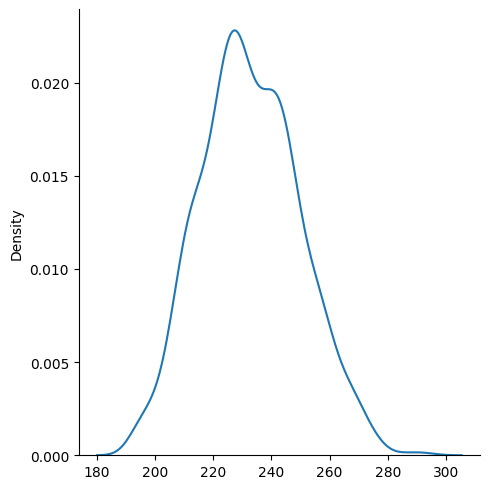

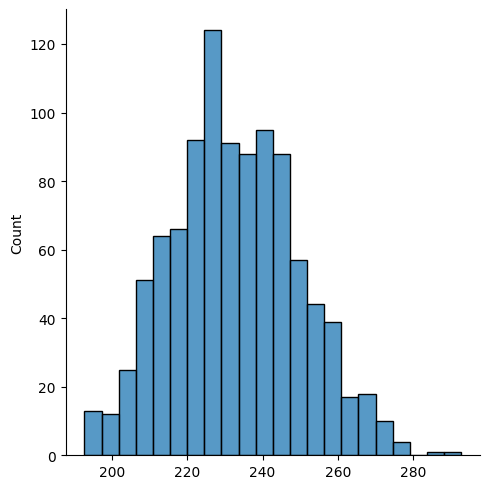

In [10]:
sns.displot(speeds, kind="kde")
sns.displot(speeds,)
plt.show()

## 3. Overall optimize

In [82]:
import itertools
import torch
from ixnos import iXnos, encode


def get_inputs(codons : list):
    nts = "".join(codons)
    codon_vector = np.concatenate([encode(i, COD2ID) for i in codons])
    nt_vector = np.concatenate([encode(i, NT2ID) for i in nts])
    input_vector = np.concatenate([codon_vector, nt_vector])
    input_vector = torch.from_numpy(input_vector).to(torch.float32)
    return input_vector

# PARAMETERS!!!
seq = cit_seq
c_rel_min, c_rel_max = -5, 4
L = len(seq)
Q = T = P = V = [[] for i in range(L)]
# Load in model
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
model = iXnos().to(device)
model_path = "models/ixnos_retrained.pth"
model.load_state_dict(torch.load(model_path, weights_only=True))
# print(model.eval())


for i in range(L):
    c_i_min = max(0, i + c_rel_min) # Originally this is 1 but I think it needs to be 0-based
    c_i_max = min(L, i + c_rel_max + 1)
    possible_codons = [let2cod[k] for k in [seq[j] for j in range(c_i_min, c_i_max)]]
    Q[i] = list(itertools.product(*possible_codons))
    if i + c_rel_min < 0:
        prefix_list = ["NNN" for j in range(c_i_min  - (i + c_rel_min))]
        Q[i] = [prefix_list + list(i) for i in Q[i]]
    for q in range(len(Q[i])):
        input_vector = get_inputs(Q[i][q]).to(device)
        T[i][q] = model(input_vector).item()
    # Another for?
    if c_i_min == 1:
        for q in Q[i]:
            P[i][q] = None
            V[i][q] = T[i][q]
    elif c_i_min > 1:
        for q in Q[i]:
            P[i][q] = np.argmin()

[['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAA', 'GGT', 'GAA'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAA', 'GGT', 'GAG'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAA', 'GGC', 'GAA'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAA', 'GGC', 'GAG'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAA', 'GGA', 'GAA'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAA', 'GGA', 'GAG'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAA', 'GGG', 'GAA'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAA', 'GGG', 'GAG'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAG', 'GGT', 'GAA'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAG', 'GGT', 'GAG'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAG', 'GGC', 'GAA'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAG', 'GGC', 'GAG'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAG', 'GGA', 'GAA'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAG', 'GGA',

KeyboardInterrupt: 

In [93]:
np.argmin(T[i][q]
          )

T[i][q]

('ATG', 'TCA', 'AAA', 'GGT', 'GAA', 'GAA', 'CTG', 'TTT', 'ACG', 'GGT')

In [63]:
print(c_i_min, c_i_max)
print(Q)

# [tuple(["NNN" for i in range(5)] + list(i)) for i in Q_i]
# list(itertools.product(*possible_codons))

0 5
[[['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAA', 'GGT', 'GAA'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAA', 'GGT', 'GAG'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAA', 'GGC', 'GAA'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAA', 'GGC', 'GAG'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAA', 'GGA', 'GAA'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAA', 'GGA', 'GAG'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAA', 'GGG', 'GAA'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAA', 'GGG', 'GAG'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAG', 'GGT', 'GAA'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAG', 'GGT', 'GAG'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAG', 'GGC', 'GAA'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAG', 'GGC', 'GAG'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAG', 'GGA', 'GAA'], ['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'ATG', 'TCT', 'AAG', '

In [104]:
class iXnos_VARIABLE(nn.Module):
    def __init__(self, n_codons = 10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.n_codons = n_codons
        self.input_layer_size = 64 * self.n_codons + 4 * 3 * self.n_codons
        self.layers = nn.Sequential(
            nn.Linear(self.input_layer_size, 200),
            nn.Tanh(),
            nn.Linear(200, 1),
            nn.ReLU(),
        )
    
    def forward(self, x):
        output = self.layers(x)
        return output 
    
m = iXnos_VARIABLE()
m.eval()

76 * 9

684